## Implementing Activation Recompute in a Simple Computation Graph

### Overview
- As you might experienced with it in last lab, Activation Recompute is a commonly used technique in LLM's training, which can save the memory footprint of training, which makes possible to train larger model with constraint resources.

- In this lab, we use FFN layer in current LLMs as an example, and try to manipulate the compute graph to make it support activation recomputation. 
- TODO List:
    + Task1: Implementing Activation Recomputation
    + Task2: Modifying Backward Pass to Utilize Recomputed Activations
    + Task3: Adding Control Dependencies of Activation Reocmputation

### Background: Activation Recomputation/Checkpointing
Activation recomputation is a common technique to reduce the memory footprint for training ML models. Before understanding how activation recomputation works, here we show a tradition forward-backward pass with no activation recomputation/checkpointing.

![forward-backward with no recomputation](./forward_backward.png)

During the **forward pass**, it goes through the model layer by layer, and generate corresponding activations. Usually these **activations** is **required** in **backward pass**, because in most operators the activation is requried to compute the gradient, thus we store them. Then in the **backward pass**, the these activations is **consumed**, and **realeased** layer by layer in a reversed manner. 

In general, during **forward** pass, the memory footprint will **grows** because we are accumilating activations in the memory, then during the **backward** pass, the memory footprint **drops**. You can observe this in the following figure (please ignore OTIMIZER_STATE for now, in naive gradient descend, SGD, we just don't have them, and for other advanced optimizers, it will be used to improve the optimization).

<img src="./memory_footprint.png" alt="forward-backward memory footprint" width="600">

The variations of memory usage is not ideal, and will limit the scale of training. Activation recomputation/checkpoint is the technique to resolve the problem. 

The basic idea of activation recomputation is that, **instead of storing all activations** from the forward pass and send them to backward pass, in activtaion recompute we just don't save these activations. Instead, when backward requires these activations, we **run another forward pass** (called recompute pass here) right in time, and use them. Here is the compute graph with activation recompute

![forward-backward with activation recomputation](./forward_backward_ar.png)

The **fundemental conflict** of forward-backward memory problem is that, **forward** and **backward** happens in **different direction**, so there will be always accumulate-and-drop loops in some scale. In practice we don't run the whole-model recompute for each backward, because fundementally activation recompute don't resolve the conflict. Instead, activation recomputation/checkpointing provide possibility to **break down** the **recompute in chunks**. With *in each chunk*, the recompute still happens in the *forward direction*, which is in conflict of backward process, and causing need to store activations within each chunk. However, *between chunks*, it is possible to run them in the *backward direction*, and the only cost is that we need to store the activation in the begining of each chunk. In the following figures we show the memory footprint with recompute in chunks.
![memory footprint: recompute in chunks](./chunks_recompute.png)


For more details, please checkout the following papers and articles in order to understand how activation recompute works
    + https://arxiv.org/pdf/1604.06174 (Especially check out Figure 3, where the conv-forward is checkpointed and other activation is recomputed.)
    + https://arxiv.org/pdf/2205.05198 (Showing how different activation checkpointing and recomputation affect final memory footprint)

**In this lab, we will implemented the FFN with recompute, and we will checkpoint the input of FFN layer and chunk in unit of the whole FFN layer**

### Prelab: Run provided toy modeling

- Because most modern ML frameworks has features called "Auto Differential", for example, pytorch, and don't have an explicit representation of backward propagation in the compute graph, here we create a very toy modeling of compute graph in the following code block. 

In [2]:
## Please run this code block at least once before doing following part of this lab 
## Codes to model a simple compute graph for this lab

%pip install graphviz

import graphviz

# operators
class OPType:   
    PLACE_HOLDER = "PLACE_HOLDER"
    MATMUL = "MATMUL"
    ADD = "ADD"
    RELU_FORWARD_BACKWARD = "RELU_FORWRAD_BACKWARD"
    SOFTMAX_FORWARD = "SOFTMAX_FORWARD"
    SOFTMAX_BACKWARD = "SOFTMAX_BACKWARD"
    NORM_FORWARD = "NORM_FORWARD"
    NORM_BACKWARD = "NORM_BACKWARD"
    
# Labeling what phase this node belongs to
class NodeType:     
    INPUT = "INPUT"
    WEIGHT = "WEIGHT"
    ACT = "ACTIVATION"
    RECOMP = "RECOMP"
    
    GRAD_WEIGHT = "GRAD_WEIGHT"
    GRAD_ACT = "GRAD_ACT"
    
    VIZ_COLOR_MAP = {
        INPUT: "lightblue",
        WEIGHT: "lightgreen",
        ACT: "yellow",
        RECOMP: "orange",
        GRAD_WEIGHT: "lightcoral",
        GRAD_ACT: "lightpink"
    }
        
# A node in the compute graph
class Node:     
    def __init__(self, name, type_, op, data_deps=None, ctrl_deps=None):
        self.name = name
        self.op = op
        if data_deps is None:
            data_deps = []
        if ctrl_deps is None:
            ctrl_deps = []
        self.data_deps = data_deps
        self.type = type_
        self.ctrl_deps = ctrl_deps


# Baseclass of all compute graph
class SimpleComputeGraph:       
    def __init__(self):
        self.graph = dict()
    
    def build_graph(self):
        raise NotImplementedError()
    
    def add_node(self, *args, **kwargs):
        node = Node(*args, **kwargs)
        self.graph[node.name] = node
        return node
    
    def visualize(self, filename, format="dot"):
        dot = graphviz.Digraph(format=format)

        for node in self.graph.values():
            node_color = NodeType.VIZ_COLOR_MAP.get(node.type, "white")
            dot.node(node.name, label=f"{node.name}: {node.op}", shape="rect", style="filled", fillcolor=node_color)

            for dep in node.data_deps:
                dot.edge(dep.name, node.name, style="solid")

            for dep in node.ctrl_deps:
                dot.edge(dep.name, node.name, style="dashed")

        dot.render(filename)
        return dot

You should consider upgrading via the '/home/hice1/jho88/ece8803_hml_lab4A/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


For reference, we also provide an implementation of forward+backward pass of the FFN block without activation recomputation. Here is a figure of architecture of a FFN block (llama style).

![FFN block architecture](./llama_ffn.png)

Now, with following example code:
- Please run it and it will print out the generate compute graph.
- Please try to understand it.

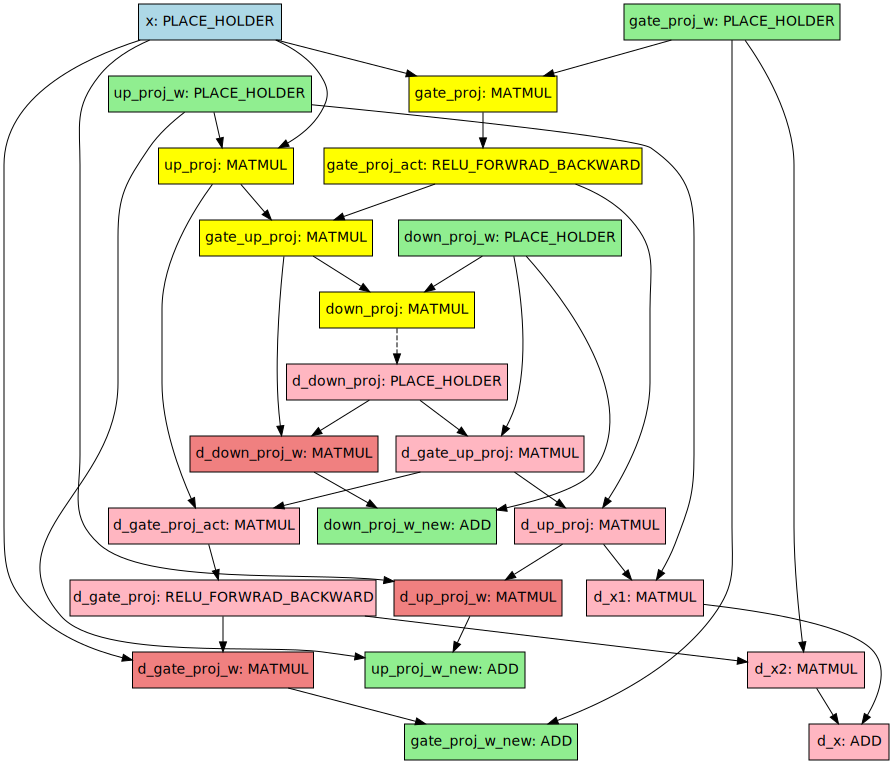

In [3]:
class LLM_MLP(SimpleComputeGraph):
    def build_graph(self):
        self.build_forward()
        self.build_backward()
        self.build_grad_update()
        
        # ctrl_deps to enforce order of backward and forward
        down_proj = self.graph['down_proj']
        d_down_proj = self.graph['d_down_proj']
        d_down_proj.ctrl_deps.append(down_proj)
        
    def build_forward(self):
        x = self.add_node("x", NodeType.INPUT, OPType.PLACE_HOLDER)

        # gate_proj
        gate_proj_w = self.add_node("gate_proj_w", NodeType.WEIGHT, OPType.PLACE_HOLDER)
        gate_proj = self.add_node("gate_proj", NodeType.ACT, OPType.MATMUL, [x, gate_proj_w])
        gate_proj_act = self.add_node("gate_proj_act", NodeType.ACT, OPType.RELU_FORWARD_BACKWARD, [gate_proj])

        # up_proj
        up_proj_w = self.add_node("up_proj_w", NodeType.WEIGHT, OPType.PLACE_HOLDER)
        up_proj = self.add_node("up_proj", NodeType.ACT, OPType.MATMUL, [x, up_proj_w])

        # gate_up_proj
        gate_up_proj = self.add_node("gate_up_proj", NodeType.ACT, OPType.MATMUL, [gate_proj_act, up_proj])

        # down_proj
        down_proj_w = self.add_node("down_proj_w", NodeType.WEIGHT, OPType.PLACE_HOLDER)
        down_proj = self.add_node("down_proj", NodeType.ACT, OPType.MATMUL, [gate_up_proj, down_proj_w])

    def build_backward(self):
        d_down_proj = self.add_node("d_down_proj", NodeType.GRAD_ACT, OPType.PLACE_HOLDER)

        # down_proj
        gate_up_proj = self.graph['gate_up_proj']
        down_proj_w = self.graph["down_proj_w"]
        d_gate_up_proj = self.add_node("d_gate_up_proj", NodeType.GRAD_ACT, OPType.MATMUL, [d_down_proj, down_proj_w])
        d_down_proj_w = self.add_node("d_down_proj_w", NodeType.GRAD_WEIGHT, OPType.MATMUL, [d_down_proj, gate_up_proj])

        # gate_up_proj
        gate_proj_act = self.graph['gate_proj_act']
        up_proj = self.graph['up_proj']
        d_gate_proj_act = self.add_node("d_gate_proj_act", NodeType.GRAD_ACT, OPType.MATMUL, [d_gate_up_proj, up_proj])
        d_up_proj = self.add_node("d_up_proj", NodeType.GRAD_ACT, OPType.MATMUL, [d_gate_up_proj, gate_proj_act])

        # up_proj
        x = self.graph['x']
        up_proj_w = self.graph['up_proj_w']
        d_x1 = self.add_node("d_x1", NodeType.GRAD_ACT, OPType.MATMUL, [d_up_proj, up_proj_w])
        d_up_proj_w = self.add_node("d_up_proj_w", NodeType.GRAD_WEIGHT, OPType.MATMUL, [d_up_proj, x])

        # gate_proj
        d_gate_proj = self.add_node("d_gate_proj", NodeType.GRAD_ACT, OPType.RELU_FORWARD_BACKWARD, [d_gate_proj_act])

        gate_proj_w = self.graph['gate_proj_w']
        d_x2 = self.add_node("d_x2", NodeType.GRAD_ACT, OPType.MATMUL, [d_gate_proj, gate_proj_w])
        d_gate_proj_w = self.add_node("d_gate_proj_w", NodeType.GRAD_WEIGHT, OPType.MATMUL, [d_gate_proj, x])

        d_x = self.add_node("d_x", NodeType.GRAD_ACT, OPType.ADD, [d_x1, d_x2])

    def build_grad_update(self):
        down_proj_w = self.graph["down_proj_w"]
        up_proj_w = self.graph['up_proj_w']
        gate_proj_w = self.graph['gate_proj_w']

        d_down_proj_w = self.graph["d_down_proj_w"]
        d_up_proj_w = self.graph['d_up_proj_w']
        d_gate_proj_w = self.graph['d_gate_proj_w']

        down_proj_w_new = self.add_node("down_proj_w_new", NodeType.WEIGHT, OPType.ADD, [down_proj_w, d_down_proj_w])
        up_proj_w_new = self.add_node("up_proj_w_new", NodeType.WEIGHT, OPType.ADD, [up_proj_w, d_up_proj_w])
        gate_proj_w_new = self.add_node("gate_proj_w_new", NodeType.WEIGHT, OPType.ADD, [gate_proj_w, d_gate_proj_w])
        
llm_mlp = LLM_MLP()
llm_mlp.build_graph()
llm_mlp_dot = llm_mlp.visualize("llm_mlp", format="dot")
llm_mlp_dot = llm_mlp.visualize("llm_mlp", format="pdf")
llm_mlp_dot


Now we will add activation recompute to the previous implementation, as shown in following template class (Please don't modify here, it is just FYI):

In [4]:
class LLM_MLP_ActRecomp(LLM_MLP):
    def build_graph(self):
        self.build_forward()
        self.build_act_recomp()
        self.build_backward()
        self.build_grad_update()
        
        # ctrl_deps to enforce order of backward and forward
        down_proj = self.graph['down_proj']
        d_down_proj = self.graph['d_down_proj']
        d_down_proj.ctrl_deps.append(down_proj)
        self.add_act_recomp_ctrl_dep()
        
        
    def build_act_recomp(self):
        # Task 1, dont modify here, implement in the later code block
        pass
        
    def build_backward(self):
        # Task 2, dont modify here, implement in the later code block
        pass
        
    def add_act_recomp_ctrl_dep(self):
        # Task 3, dont modify here, implement in the later code block
        pass

In the code, there will be three parts you need to fill in:
- Task 1: Complete the compute graph related to activation recomputation
- Task 2: Modify the backward graph in order to utilize the recomputed activation
- Task 3: Add control dependancy to make the recomputation happens as correct timing.

### Task 1: Activation Recomputation
- Please complete the following block for activation recompute logics
- Assume we only save the "x" activation in the forward pass, which means that is the only activation you should use during backward.
- All other activation should be recomputed here before backward.
- If you not clear about the graph structure, please understand it should be very similar to the normal forward, and please refer to the previous forward implementation.
- Note:
    + You should only access "x" and weights in this part.
    + **IMPORTANT**: Please suffix the recomputed activation with "_recomp" suffix and with NodeType of "NodeType.RECOMP" for correct auto grading.

In [20]:
def build_act_recomp(self):
    x = self.graph['x']     # assume this is the only activation we saved for backward
        
    # recomp node example
    # gate_proj_recomp = self.add_node("gate_proj_recomp", NodeType.RECOMP, ...)

    # TODO: complete the code here
    # gate_proj
    gate_proj_w = self.graph['gate_proj_w']
    gate_proj_recomp = self.add_node("gate_proj_recomp", NodeType.RECOMP, OPType.MATMUL, [x, gate_proj_w])
    gate_proj_act_recomp = self.add_node("gate_proj_act_recomp", NodeType.RECOMP, OPType.RELU_FORWARD_BACKWARD, [gate_proj_recomp])

    # up_proj
    up_proj_w = self.graph['up_proj_w']
    up_proj_recomp = self.add_node("up_proj_recomp", NodeType.RECOMP, OPType.MATMUL, [x, up_proj_w])

    # gate_up_proj
    gate_up_proj_recomp = self.add_node("gate_up_proj_recomp", NodeType.RECOMP, OPType.MATMUL, [gate_proj_act_recomp, up_proj_recomp])

    # # down_proj
    # down_proj_w = self.graph['down_proj_w']
    # down_proj_recomp = self.add_node("down_proj_recomp", NodeType.RECOMP, OPType.MATMUL, [gate_up_proj_recomp, down_proj_w])

### Task 2: Modify Backward to Utilize Recomputed Activation
- With recomputed activation, rewrite backward using recomputed activations.
- Please refer to the backward implementation in previous reference. The only changes required to change the linked activation from forward to recomputed.
- Note: you should only access "x", weights, and recomputed activations in this part.

In [22]:
def build_backward(self):
    x = self.graph['x']
    d_down_proj = self.add_node("d_down_proj", NodeType.GRAD_ACT, OPType.PLACE_HOLDER)
        
    # TODO: complete the code here
    
    # down_proj
    gate_up_proj_recomp = self.graph['gate_up_proj_recomp']
    down_proj_w = self.graph["down_proj_w"]
    d_gate_up_proj = self.add_node("d_gate_up_proj", NodeType.GRAD_ACT, OPType.MATMUL, [d_down_proj, down_proj_w])
    d_down_proj_w = self.add_node("d_down_proj_w", NodeType.GRAD_WEIGHT, OPType.MATMUL, [d_down_proj, gate_up_proj_recomp])

    # gate_up_proj
    gate_proj_act_recomp = self.graph['gate_proj_act_recomp']
    up_proj_recomp = self.graph['up_proj_recomp']
    d_gate_proj_act = self.add_node("d_gate_proj_act", NodeType.GRAD_ACT, OPType.MATMUL, [d_gate_up_proj, up_proj_recomp])
    d_up_proj = self.add_node("d_up_proj", NodeType.GRAD_ACT, OPType.MATMUL, [d_gate_up_proj, gate_proj_act_recomp])

    # up_proj
    up_proj_w = self.graph['up_proj_w']
    d_x1 = self.add_node("d_x1", NodeType.GRAD_ACT, OPType.MATMUL, [d_up_proj, up_proj_w])
    d_up_proj_w = self.add_node("d_up_proj_w", NodeType.GRAD_WEIGHT, OPType.MATMUL, [d_up_proj, x])

    # gate_proj
    d_gate_proj = self.add_node("d_gate_proj", NodeType.GRAD_ACT, OPType.RELU_FORWARD_BACKWARD, [d_gate_proj_act])

    gate_proj_w = self.graph['gate_proj_w']
    d_x2 = self.add_node("d_x2", NodeType.GRAD_ACT, OPType.MATMUL, [d_gate_proj, gate_proj_w])
    d_gate_proj_w = self.add_node("d_gate_proj_w", NodeType.GRAD_WEIGHT, OPType.MATMUL, [d_gate_proj, x])
    
    d_x = self.add_node("d_x", NodeType.GRAD_ACT, OPType.ADD, [d_x1, d_x2])

### Task 3: Add Ctrl Dependancy of Recompute to make it run at correct timing.
- Add correct ctrl dependancy in order to make sure the compute happens **right before** backward
- Note: You can assume "d_down_proj" is the last operation of previous layer's backward and before this layer's backward

In [38]:
def add_act_recomp_ctrl_dep(self):
    d_down_proj = self.graph['d_down_proj']
    # example adding ctrl dependancy: if we want run b after finishing a
    # b.ctrl_deps.append(a)
    
    # TODO: complete the code here
    up_proj_recomp = self.graph['up_proj_recomp']
    d_gate_proj_act = self.graph['d_gate_proj_act']
    d_gate_proj_act.ctrl_deps.append(up_proj_recomp)

    gate_proj_act_recomp = self.graph['gate_proj_act_recomp']
    d_up_proj = self.graph['d_up_proj']
    d_up_proj.ctrl_deps.append(gate_proj_act_recomp)

    down_proj = self.graph['down_proj']
    d_down_proj = self.graph['d_down_proj']
    # d_down_proj.ctrl_deps.append(down_proj)
    
    # 2. Ensure that backward operations that depend on recomputed activations wait for them.
    # For instance, backward for down projection uses gate_up_proj_recomp.
    gate_up_proj_recomp = self.graph['gate_up_proj_recomp']
    d_down_proj_w = self.graph.get("d_down_proj_w")
    d_down_proj_w.ctrl_deps.append(gate_up_proj_recomp)

    d_down_proj.ctrl_deps.append(gate_up_proj_recomp)

    gate_proj_recomp = self.graph['gate_proj_recomp']
    gate_proj_recomp.ctrl_deps.append(down_proj)
    up_proj_recomp.ctrl_deps.append(down_proj)
    gate_up_proj_recomp.ctrl_deps.append(down_proj)
    gate_proj_act_recomp.ctrl_deps.append(down_proj)

    


### Wrapup
- With implemented parts, here we wrapping them up and get the final results of activation recomputation by running following codes

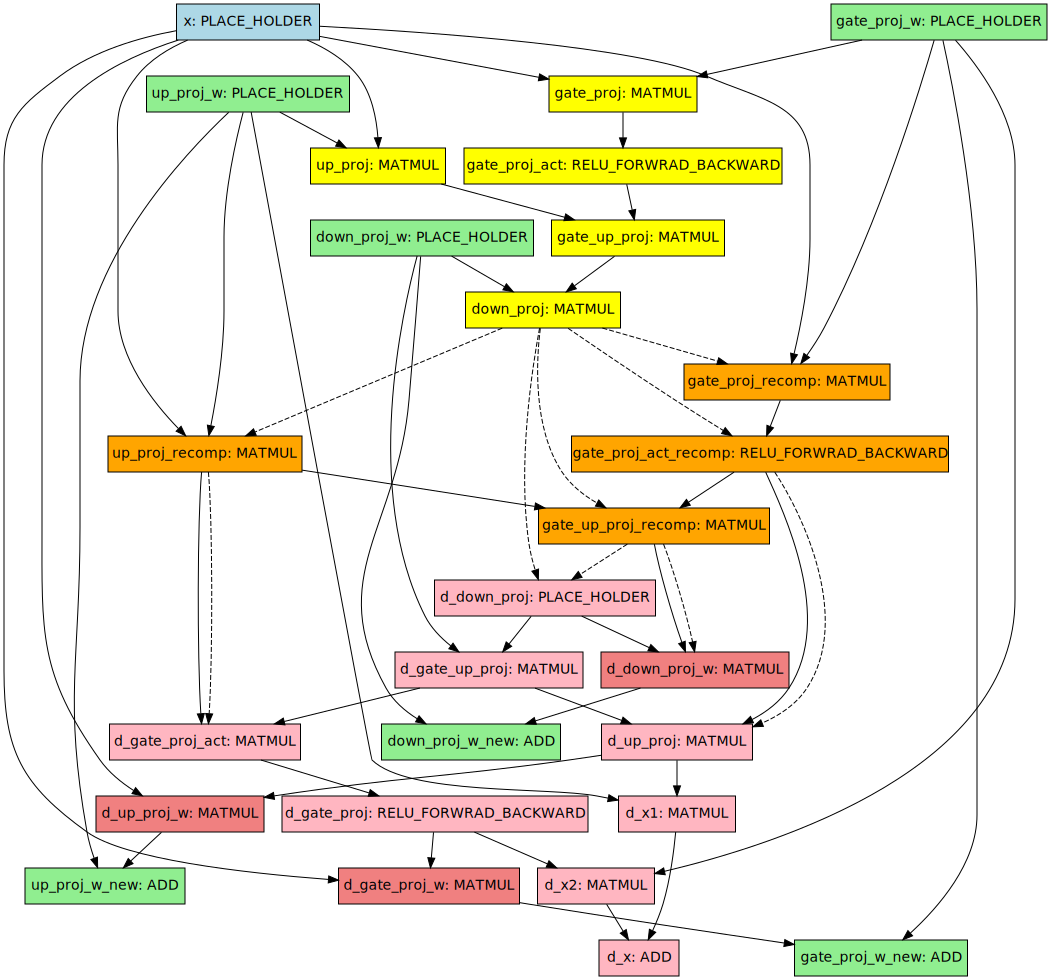

In [39]:
LLM_MLP_ActRecomp.build_act_recomp = build_act_recomp
LLM_MLP_ActRecomp.build_backward = build_backward
LLM_MLP_ActRecomp.add_act_recomp_ctrl_dep = add_act_recomp_ctrl_dep

# if you see compiling errors, you did something wrong in the previous tasks
llm_mlp_ar = LLM_MLP_ActRecomp()
llm_mlp_ar.build_graph()
llm_mlp_ar_dot = llm_mlp_ar.visualize("llm_mlp_ar", format="dot")
llm_mlp_ar_dot = llm_mlp_ar.visualize("llm_mlp_ar", format="pdf")
llm_mlp_ar_dot

### Submissions
Please pack the following files in a single zip file with naming f"{FirstName}_{LastName}.zip" for submission (example, "Changhai_Man.zip").
- This jupyter notebook with filled codes.
- Generated graph:
    - llm_mlp.dot
    - llm_mlp_ar.dot